In [1]:
import numpy as np
import math
import torch
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import Image
import os
%matplotlib inline

## SegmentNode Class

In [2]:
# TreeNode class to hold the data
# val : interpolated value of region
class TreeNode:
    def __init__(self,top,bot,left,right,save_dir='reconstruction'):
        # parameters of specific node
        self.top = top 
        self.bot = bot
        self.left = left
        self.right = right
        
        # 4 children here
        self.top_left = None
        self.top_right = None
        self.bot_left = None
        self.bot_right = None
        
        self.save_dir = save_dir
        if not os.path.exists(self.save_dir):
            os.mkdir(self.save_dir)
        self.node_dir = 'node_' + str(self.top) + '_' + str(self.bot) + '_' + str(self.left) + '_' + str(self.right)
        self.node_dir = os.path.join(self.save_dir,self.node_dir)
        if not os.path.exists(self.node_dir):
            os.mkdir(self.node_dir)
        
        self.tested = False
        
    def standardize(self,x):     
        x_min = np.min(x,axis=(1,2),keepdims=True)
        x_max = np.max(x,axis=(1,2),keepdims=True)
        x = (x - x_min) / (x_max + 1E-15)
        return x,x_min,x_max
        
    def numChildren(self):
        num_children = 0
        for child in (self.top_left,self.top_right,self.bot_left,self.bot_right):
            if child:
                num_children += 1
        return num_children        
    
    def getChildren(self):
        children = []
        for child in (self.top_left,self.top_right,self.bot_left,self.bot_right):
            if child:
                children.append(child)
        return children
    
    def makeAutoEncoder(self,x,prev_residual):
        x_standardized,_,_ = self.standardize(x)
        batches,rows,cols = x_standardized.shape
        in_data_flattened = x_standardized.reshape(batches,rows*cols)
        
        # TODO Should I standardize the residuals?
        #prev_resid_standardized,prev_resid_min,prev_resid_max = self.standardize(residual)
        batches,self.y_rows,self.y_cols = prev_residual.shape
        prev_residual_flattened = prev_residual.reshape(batches,self.y_rows*self.y_cols)
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.encoder_model = encoderModel(in_data_flattened,prev_residual_flattened,self.node_dir,self.device)
        
    def trainAutoEncoder(self,save_dir='reconstruction'):    
        self.encoder_model.train()
        
    def testAutoEncoder(self,test_data):    
        test_data_standardized,_,_ = self.standardize(test_data)
        batches,rows,cols = test_data_standardized.shape
        test_data_flattened = test_data_standardized.reshape(batches,rows*cols)
        
        self.encoder_model.model = torch.load(os.path.join(self.node_dir,'model.pth')).to(self.device)
        self.encoder_model.model.eval()
        
        resid_reconstruction = None
        batch_size = 8
        test_dataloader = DataLoader(torch.Tensor(test_data_flattened),shuffle=False,batch_size=batch_size)
        for test_batch in test_dataloader:
            
            batch_resid = self.encoder_model.model(test_batch.to(self.device))
            
            batch_resid = batch_resid.detach().cpu().numpy()
            bs,_ = batch_resid.shape
            batch_resid = batch_resid.reshape(bs,self.y_rows,self.y_cols)
            if resid_reconstruction is None:
                resid_reconstruction = batch_resid
            else:
                resid_reconstruction = np.concatenate([resid_reconstruction,batch_resid],axis=0)
        del self.encoder_model.model
        torch.cuda.empty_cache()
        self.tested = True
        return np.array(resid_reconstruction)
        
    def addChildren(self):
        h = self.bot - self.top
        w = self.right - self.left
        if w > 1 or h > 1:
            h_mid = self.left + math.ceil(w/2)
            v_mid = self.top + math.ceil(h/2)
            sub_h_mid = math.ceil(w/2)
            sub_v_mid = math.ceil(h/2)

            if w == 1:
                self.top_left = TreeNode(self.top,v_mid,self.left,h_mid)
                self.bot_left = TreeNode(v_mid,self.bot,self.left,h_mid)
            elif h == 1:
                self.top_left = TreeNode(self.top,v_mid,self.left,h_mid)
                self.top_right = TreeNode(self.top,v_mid,h_mid,self.right)
            else:    
                self.top_left = TreeNode(self.top,v_mid,self.left,h_mid)
                self.top_right = TreeNode(self.top,v_mid,h_mid,self.right)
                self.bot_left = TreeNode(v_mid,self.bot,self.left,h_mid)
                self.bot_right = TreeNode(v_mid,self.bot,h_mid,self.right)
    
    def getBounds(self,p=False):
        bounds = [self.top,self.bot,self.left,self.right]
        if p:
            print('node(top,bot,left,right) : node({})'.format(bounds))
        else:    
            return bounds
              
    def getNodeData(self,p=False):
        if p:
            print('self.x.shape : {}'.format(self.x.shape))
            print('self.prev_residual.shape : {}'.format(self.prev_residual.shape))
            if self.tested:
                print('self.curr_residual.shape : {}'.format(self.curr_residual.shape))
                print('self.resid_reconstruction.shape : {}'.format(self.resid_reconstruction.shape))
        else:    
            if self.tested:
                return self.x, self.prev_residual, self.curr_residual, self.resid_reconstruction
            else:
                return self.x, self.prev_residual

## Autoencoder Model + Training Setup

In [3]:
class AE(torch.nn.Module):
    
    def __init__(self,input_size,output_size):
        super().__init__()
        
        #print('input_size :',input_size)
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(input_size,64),
            torch.nn.LeakyReLU(0.1),
            torch.nn.Linear(64,8),
            torch.nn.LeakyReLU(0.1),
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(8,64),
            torch.nn.LeakyReLU(0.1),
            torch.nn.Linear(64,output_size),
        )
            
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [4]:
class encoderModel:
    
    def __init__(self,x,y,node_dir,device='cuda:0'):
        tensor_x = torch.Tensor(x)
        tensor_y = torch.Tensor(y)
        torch_dataset = TensorDataset(tensor_x,tensor_y)
        self.train_dataloader = DataLoader(torch_dataset,shuffle=True,batch_size=8)
        self.node_dir = node_dir
        self.device = device
        
        batches,input_size = x.shape
        batches,output_size = y.shape
        self.model = AE(input_size,output_size).to(device)
    
    def train(self,epochs=200):
        
        self.loss_fn = torch.nn.MSELoss(reduction='sum').to(self.device)
        learning_rate = 1e-3    
        self.optimizer = torch.optim.RMSprop(self.model.parameters(), lr=learning_rate)
        
        self.model.cuda()
        for epoch in range(epochs):
            for data in self.train_dataloader:
                x,y = data
                
                y_pred = self.model(x.to(self.device))
                loss = self.loss_fn(y_pred,y.to(self.device))

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

            if epoch % 100 == 99:
                print('\t\tEpoch {}\t Loss : {}'.format(epoch, loss.item()))
                
        torch.save(self.model,os.path.join(self.node_dir,'model.pth'))
        del self.model
        del self.loss_fn
        torch.cuda.empty_cache()

## Loading Data & Building Segment Tree (Reconstruction)

In [5]:
data = np.load('marsigli_flow2.npy')
print('data.shape :',data.shape)
samples,bot,right = data.shape
    
random_seed = 1234
np.random.seed(random_seed)
randomized_idx = np.random.permutation(samples)

train_idx = randomized_idx[:int(0.75*samples)]
val_idx = randomized_idx[int(0.75*samples):]
train_data = data[train_idx]
val_data = data[val_idx]
print('train_data.shape :',train_data.shape)
print('val_data.shape :',val_data.shape)

save_dir = 'reconstruction'
seg_nodes = [[-1,TreeNode(0,bot,0,right,save_dir)]]

# reconstruction_record holds the reconstructed image at each layer
training_reconstruction_record = [np.zeros(train_data.shape)]
testing_reconstruction_record = [np.zeros(val_data.shape)]
# region_record holds the boundaries of each segment used at each layer
region_record = [[[0,bot,0,right]]]

data.shape : (201, 128, 512)
train_data.shape : (150, 128, 512)
val_data.shape : (51, 128, 512)


## Running Autoencoder

In [6]:
# Start with the broadest autoencoder (whole dataset)
# Each node represents one autoencoder of one region of the image
# Iteratively replace the worse node with its children nodes
# for the desired number of levels or until the overall reconstruction error is under the mse_threshold

max_levels = 5
levels_used = 0
mse_threshold = 0.01 

for level in range(max_levels):
    print('\nAUTOENCODER LEVEL {}'.format(level))
    # Add residual reconstruction to previous reconstruction
    training_reconstruction_record.append(training_reconstruction_record[level].copy())
    testing_reconstruction_record.append(testing_reconstruction_record[level].copy())
    region_record.append([])
    levels_used += 1
    
    for i,region in enumerate(seg_nodes):
        mse, node = region
        if mse < 0:
            t,b,l,r = node.getBounds()
            print('\n\tNode(top,bot,left,right) : Node({},{},{},{})'.format(t,b,l,r))
            
            train_residual = train_data[:,t:b,l:r] - training_reconstruction_record[level][:,t:b,l:r]
            node.makeAutoEncoder(train_data,train_residual)
            node.trainAutoEncoder()
            train_reconstruction = node.testAutoEncoder(train_data)
            test_reconstruction = node.testAutoEncoder(val_data)
            
            training_reconstruction_record[level+1][:,t:b,l:r] += train_reconstruction
            testing_reconstruction_record[level+1][:,t:b,l:r] += test_reconstruction
            
            # Use the TRAINING reconstruction loss to segment the autoencoder
            loss = np.mean(np.square(np.subtract(train_data[:,t:b,l:r],training_reconstruction_record[level+1][:,t:b,l:r])))
            print('\tResidual reconstruction loss : {}'.format(loss))
            seg_nodes[i][0] = loss                          
            
    # Adds the currently used nodes into a list for visualization purposes later
    for i,region in enumerate(seg_nodes):
        mse, node = region
        t,b,l,r = node.getBounds()
        region_record[level+1].append([t,b,l,r])
        
    overall_reconstruction_mse = np.mean(np.square(np.subtract(train_data,training_reconstruction_record[-1])))
    print('\n\tOverall reconstruction loss : {}'.format(overall_reconstruction_mse))
    if mse_threshold:
        if overall_reconstruction_mse < mse_threshold:
            break
    
    # replace the worst node with its children
    seg_nodes.sort(reverse=True,key=lambda x:x[0])
    subRegionFound = False
    while subRegionFound == False:
        mse,worst_node = seg_nodes.pop(0)
        worst_node.addChildren()
        
        children = worst_node.getChildren()
        
        if worst_node.numChildren() > 0:
            t,b,l,r = worst_node.getBounds()
            print('\tSegmenting Node({},{},{},{})\n'.format(t,b,l,r))
            subRegionFound = True
            
            for child in worst_node.getChildren():
                #child.getBounds(p=True)
                #child.getNodeData(p=True)
                seg_nodes.append([-1,child])


AUTOENCODER LEVEL 0

	Node(top,bot,left,right) : Node(0,128,0,512)
		Epoch 99	 Loss : 106691.796875
		Epoch 199	 Loss : 46571.5234375
	Residual reconstruction loss : 0.14270183896888522

	Overall reconstruction loss : 0.14270183896888522
	Segmenting Node(0,128,0,512)


AUTOENCODER LEVEL 1

	Node(top,bot,left,right) : Node(0,64,0,256)
		Epoch 99	 Loss : 20880.23828125
		Epoch 199	 Loss : 14688.23046875
	Residual reconstruction loss : 0.09648871902871807

	Node(top,bot,left,right) : Node(0,64,256,512)
		Epoch 99	 Loss : 1368.4228515625
		Epoch 199	 Loss : 523.9351806640625
	Residual reconstruction loss : 0.006488660075395392

	Node(top,bot,left,right) : Node(64,128,0,256)
		Epoch 99	 Loss : 3042.398681640625
		Epoch 199	 Loss : 603.0973510742188
	Residual reconstruction loss : 0.00625499446170578

	Node(top,bot,left,right) : Node(64,128,256,512)
		Epoch 99	 Loss : 18664.44140625
		Epoch 199	 Loss : 44271.19921875
	Residual reconstruction loss : 0.19957236080402224

	Overall reconstructi

## Plotting Some Analysis/Results

MovieWriter imagemagick unavailable; using Pillow instead.


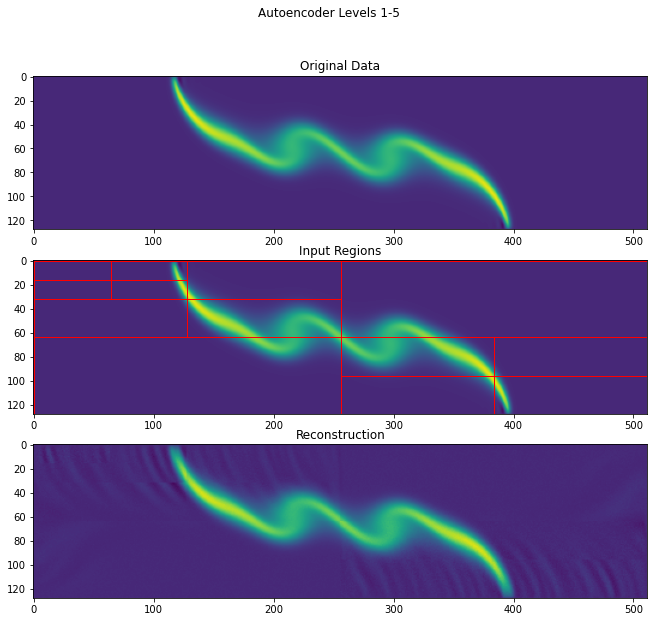

In [7]:
import matplotlib.animation as anim

class AnimatedGif:
    
    def __init__(self,vmin,vmax,size=(1280,960)):
        self.fig = plt.figure()
        self.fig.set_size_inches(size[0] / 100, size[1] / 100)
        self.ax0 = self.fig.add_subplot(311)
        self.ax1 = self.fig.add_subplot(312)
        self.ax2 = self.fig.add_subplot(313)
        self.images = []
        self.vmin = vmin
        self.vmax = vmax
        
    def add(self, oimg, in_regions, reconstruction, reg_record, lvl='' ):
        sup_title = self.fig.suptitle('Autoencoder Levels 1-'+lvl)
        ax311_title = self.ax0.set_title('Original Data')
        plt_img311 = self.ax0.imshow(oimg,vmin=self.vmin,vmax=self.vmax,animated=True)
        ax312_title = self.ax1.set_title('Input Regions')
        plt_img312 = self.ax1.imshow(in_regions,vmin=self.vmin,vmax=self.vmax,animated=True)
        recs = []
        for region in reg_record:
            t,b,l,r = region
            h = b-t
            w = r-l
            rec = self.ax1.add_patch(patches.Rectangle((l,t),w,h,linewidth=1,edgecolor='r',facecolor='none'))
            recs.append(rec)
        ax313_title = self.ax2.set_title('Reconstruction')
        plt_img313 = self.ax2.imshow(reconstruction,vmin=self.vmin,vmax=self.vmax,animated=True)
        self.images.append([plt_img311,plt_img312,plt_img313,ax311_title,ax312_title,ax313_title,sup_title]+recs)
        
    def save(self, filename):
        animation = anim.ArtistAnimation(self.fig, self.images)
        animation.save(filename, writer='imagemagick', fps = 2)
        
time_slice_num = 2
rec_record = np.array(testing_reconstruction_record)[:,time_slice_num,:,:]
animated_gif = AnimatedGif(np.min(rec_record),np.max(rec_record))

for i in range(1,levels_used+1):
    animated_gif.add(val_data[time_slice_num], val_data[time_slice_num], rec_record[i], region_record[i], lvl=str(i))
animated_gif.save(os.path.join(save_dir,'segEncoder_reconstruction.gif'))
Image(url=os.path.join(save_dir,'segEncoder_reconstruction.gif'))

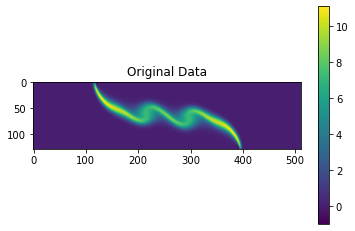

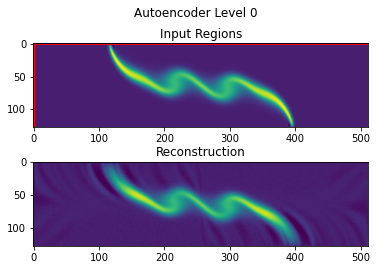

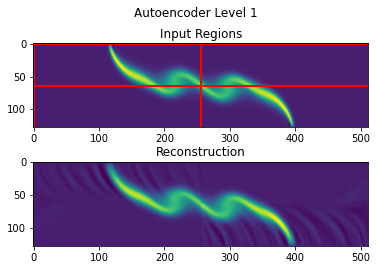

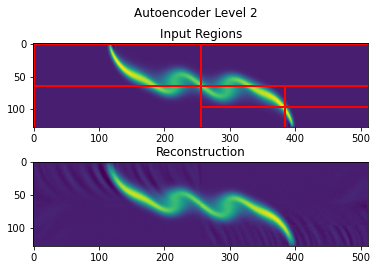

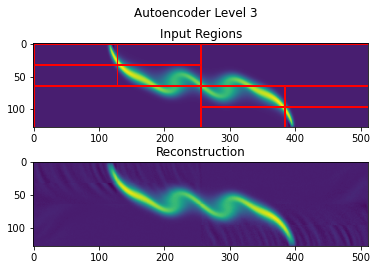

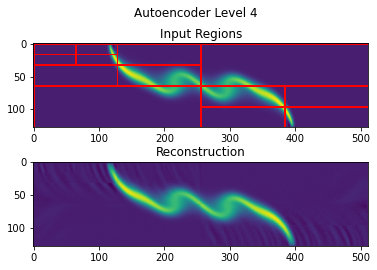

In [8]:
time_slice_num = 2

plt.figure(0)
plt.title('Original Data')
plt.imshow(val_data[time_slice_num])
plt.colorbar()

for i in range(1,levels_used+1):
    plt.figure(i+1)
    plt.suptitle('Autoencoder Level {}'.format(i-1))
    plt.subplot(211)
    plt.title('Input Regions')
    plt.imshow(val_data[time_slice_num])
    plt.clim(np.min(val_data[time_slice_num]),np.max(val_data[time_slice_num]))
    regions = region_record[i]
    for region in regions:
        t,b,l,r = region
        h = b-t
        w = r-l
        plt.gca().add_patch(patches.Rectangle((l,t),w-1,h-1,linewidth=1,edgecolor='r',facecolor='none'))
    plt.subplot(212)
    plt.title('Reconstruction')
    plt.imshow(testing_reconstruction_record[i][time_slice_num])
    plt.clim(np.min(val_data[time_slice_num]),np.max(val_data[time_slice_num]))
    plt.savefig('fig{}.png'.format(i))

## ELM Class

In [9]:
class ELM:
    
    def __init__(self,x,y):
        self.x = x
        self.y = y
        n_hidden = 8
        samples,_ = self.x.shape
        self.w1 = np.random.random((n_hidden,samples))
        #self.w1 = np.repeat(self.w1,samples,axis=1)
        self.b1 = np.random.random((n_hidden,1))
        self.w2 = None
        
    def tanSigmoid(self,x):
        return (1 - np.exp(-2*x)) / (1 + np.exp(-2*x))
    
    def calcW2(self):
        hidden = self.tanSigmoid( np.matmul(self.w1,self.x) + self.b1 ).T
        hDagger = np.linalg.pinv(hidden)
        w2T = np.matmul(hDagger,self.y.T)
        self.w2 = w2T.T
        
    def predict(self,data_test):
        if self.w2 == None:
            self.calcW2()
            
        x1 = self.tanSigmoid( np.matmul(self.w1,data_test) + self.b1 )
        x2 = np.matmul(self.w2,x1)
        return x2

<Figure size 432x288 with 0 Axes>

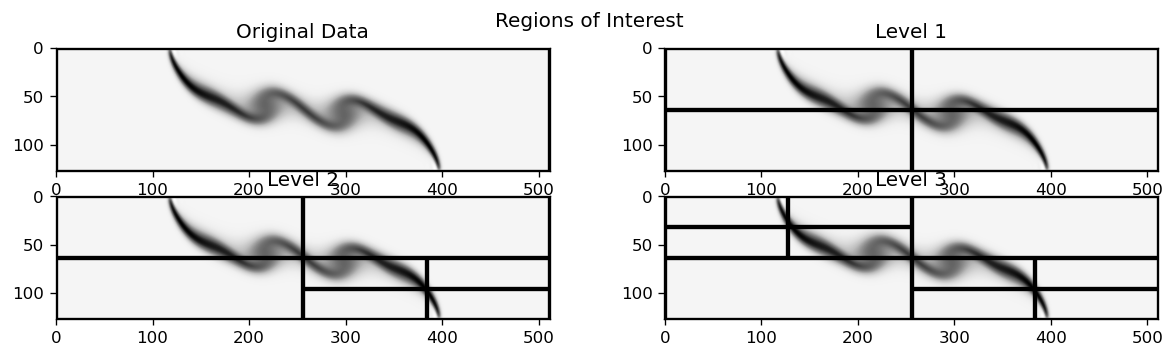

In [10]:
time_slice_num = 2

plt.figure(0)
plt.figure(figsize=(12,3),dpi=120)

plt.suptitle('Regions of Interest')
plt.subplot(221)
plt.title('Original Data')
plt.imshow(val_data[time_slice_num],cmap='Greys')
regions = region_record[1]
for region in regions:
    t,b,l,r = region
    h = b-t
    w = r-l
    plt.gca().add_patch(patches.Rectangle((l,t),w-1,h-1,linewidth=2,edgecolor='black',facecolor='none'))
plt.subplot(222)
plt.title('Level 1')
plt.imshow(val_data[time_slice_num],cmap='Greys')
regions = region_record[2]
for region in regions:
    t,b,l,r = region
    h = b-t
    w = r-l
    plt.gca().add_patch(patches.Rectangle((l,t),w-1,h-1,linewidth=2,edgecolor='black',facecolor='none'))
plt.subplot(223)
plt.title('Level 2')
plt.imshow(val_data[time_slice_num],cmap='Greys')
regions = region_record[3]
for region in regions:
    t,b,l,r = region
    h = b-t
    w = r-l
    plt.gca().add_patch(patches.Rectangle((l,t),w-1,h-1,linewidth=2,edgecolor='black',facecolor='none'))
plt.subplot(224)
plt.title('Level 3')
plt.imshow(val_data[time_slice_num],cmap='Greys')
regions = region_record[4]
for region in regions:
    t,b,l,r = region
    h = b-t
    w = r-l
    plt.gca().add_patch(patches.Rectangle((l,t),w-1,h-1,linewidth=2,edgecolor='black',facecolor='none'))


plt.savefig('fig_proposal.png')
plt.show()

<Figure size 432x288 with 0 Axes>

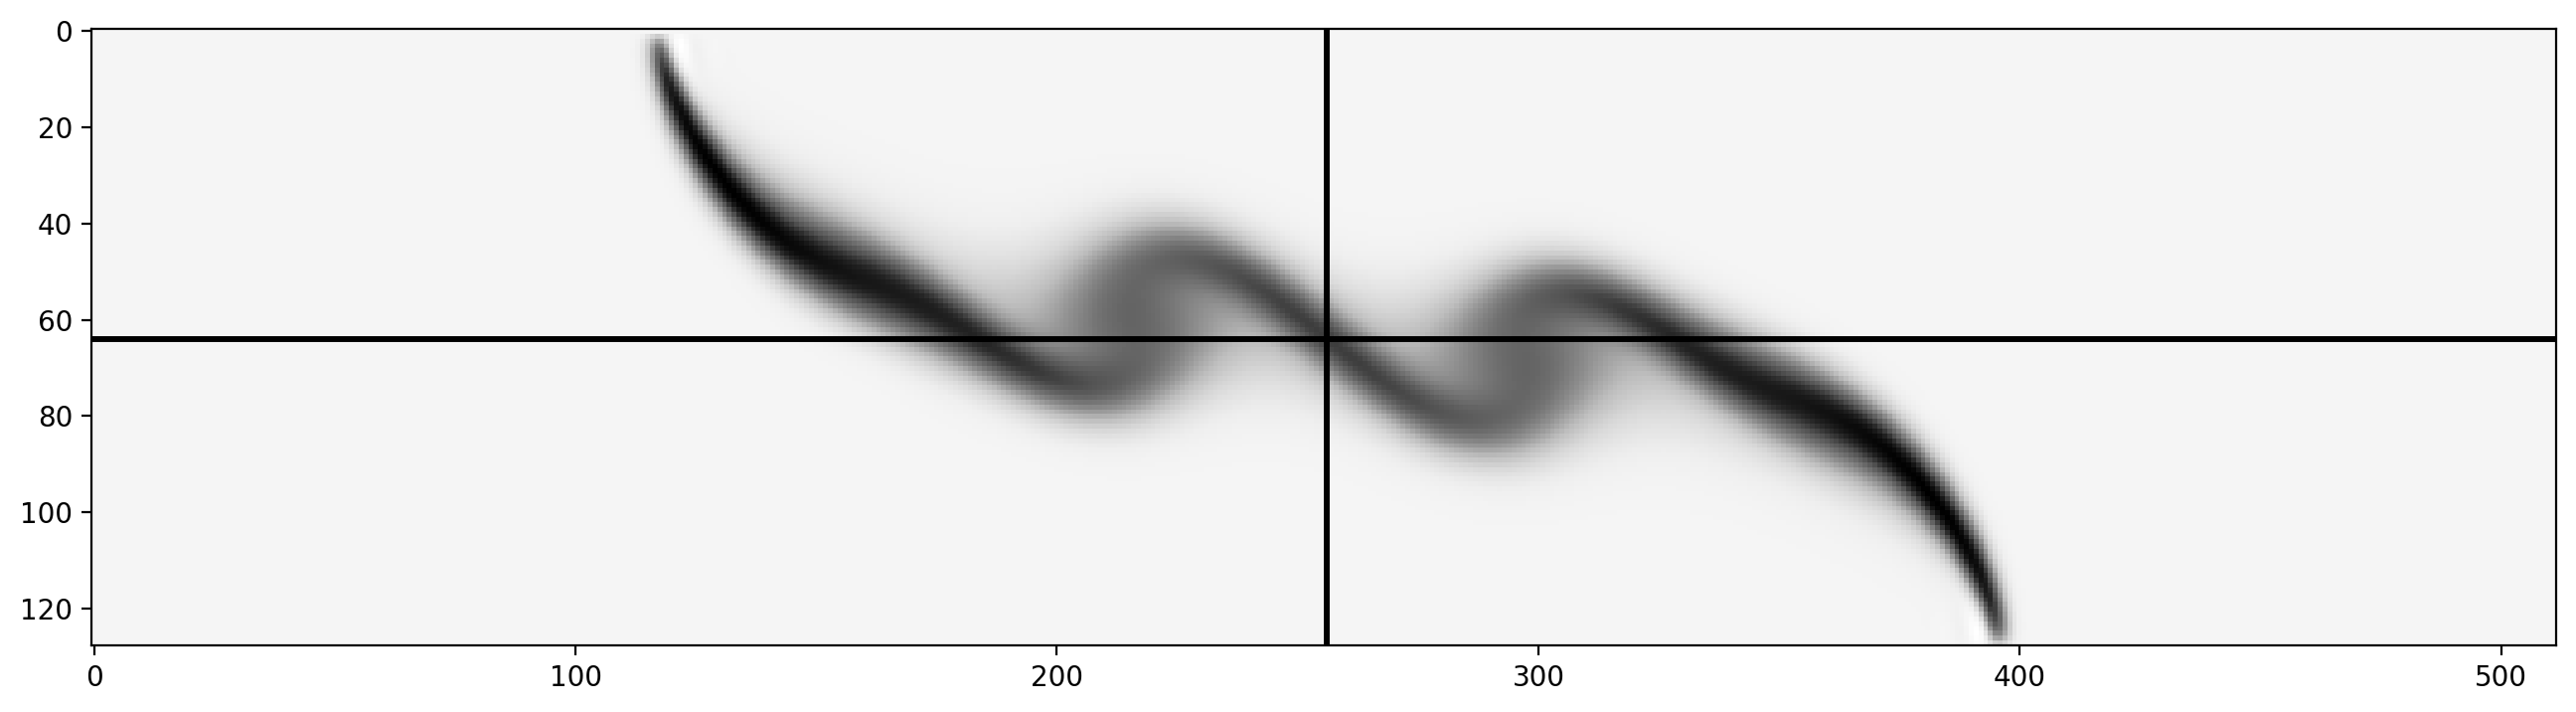

In [36]:
region_example = [[-1, 64, -1, 256],
 [-1, 64, 256, 513],
 [64, 129, -1, 256],
 [64, 129, 256, 513]]

plt.figure()
plt.figure(figsize=(16,12),dpi=200)
#plt.title('Nested Network')
plt.imshow(val_data[time_slice_num],cmap='Greys')
regions = region_example
for region in regions:
    t,b,l,r = region
    h = b-t
    w = r-l
    plt.gca().add_patch(patches.Rectangle((l,t),w,h,linewidth=2,edgecolor='black',facecolor='none'))
    
plt.savefig('fig_proposal2.png')

<Figure size 432x288 with 0 Axes>

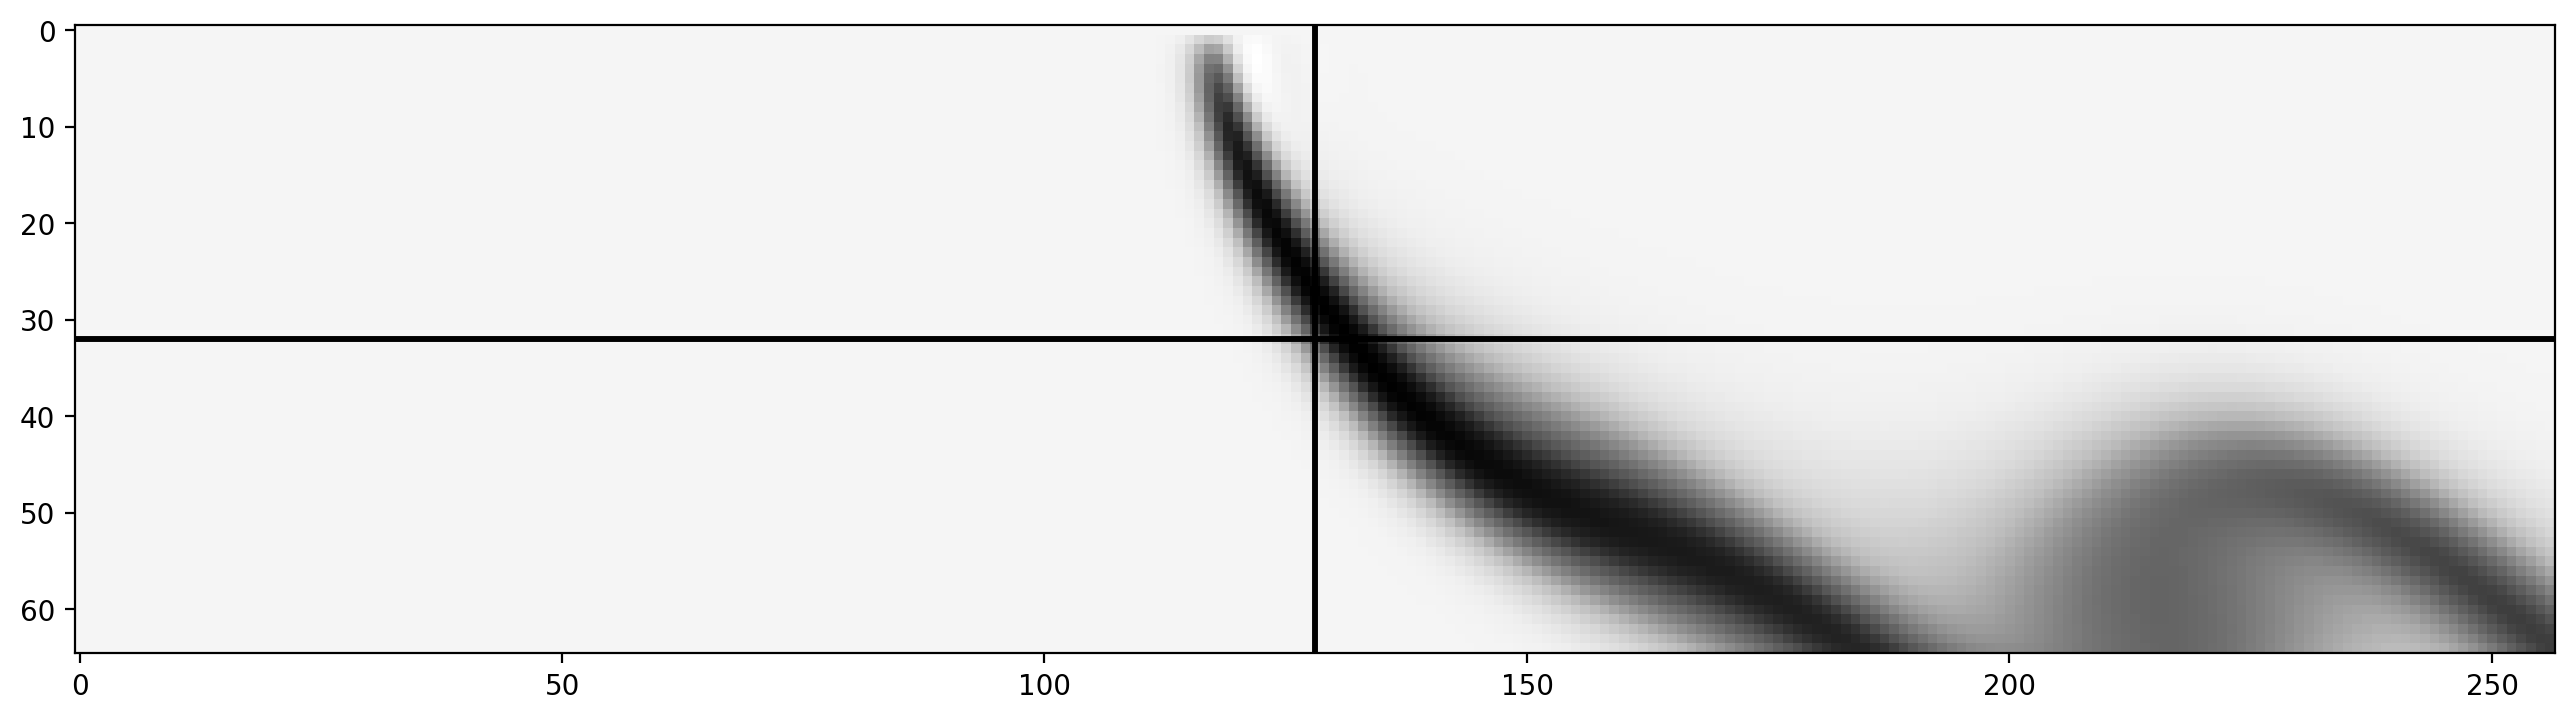

In [37]:
region_example = [[-1, 32, -1, 128],
 [-1, 32, 128, 257],
 [32, 65, -1, 128],
 [32, 65, 128, 257]]

plt.figure()
plt.figure(figsize=(16,12),dpi=200)
#plt.title('Nested Network')
plt.imshow(val_data[time_slice_num][:65,:257],cmap='Greys')
regions = region_example
for region in regions:
    t,b,l,r = region
    h = b-t
    w = r-l
    plt.gca().add_patch(patches.Rectangle((l,t),w,h,linewidth=2,edgecolor='black',facecolor='none'))
    
plt.savefig('fig_proposal3.png')

<Figure size 432x288 with 0 Axes>

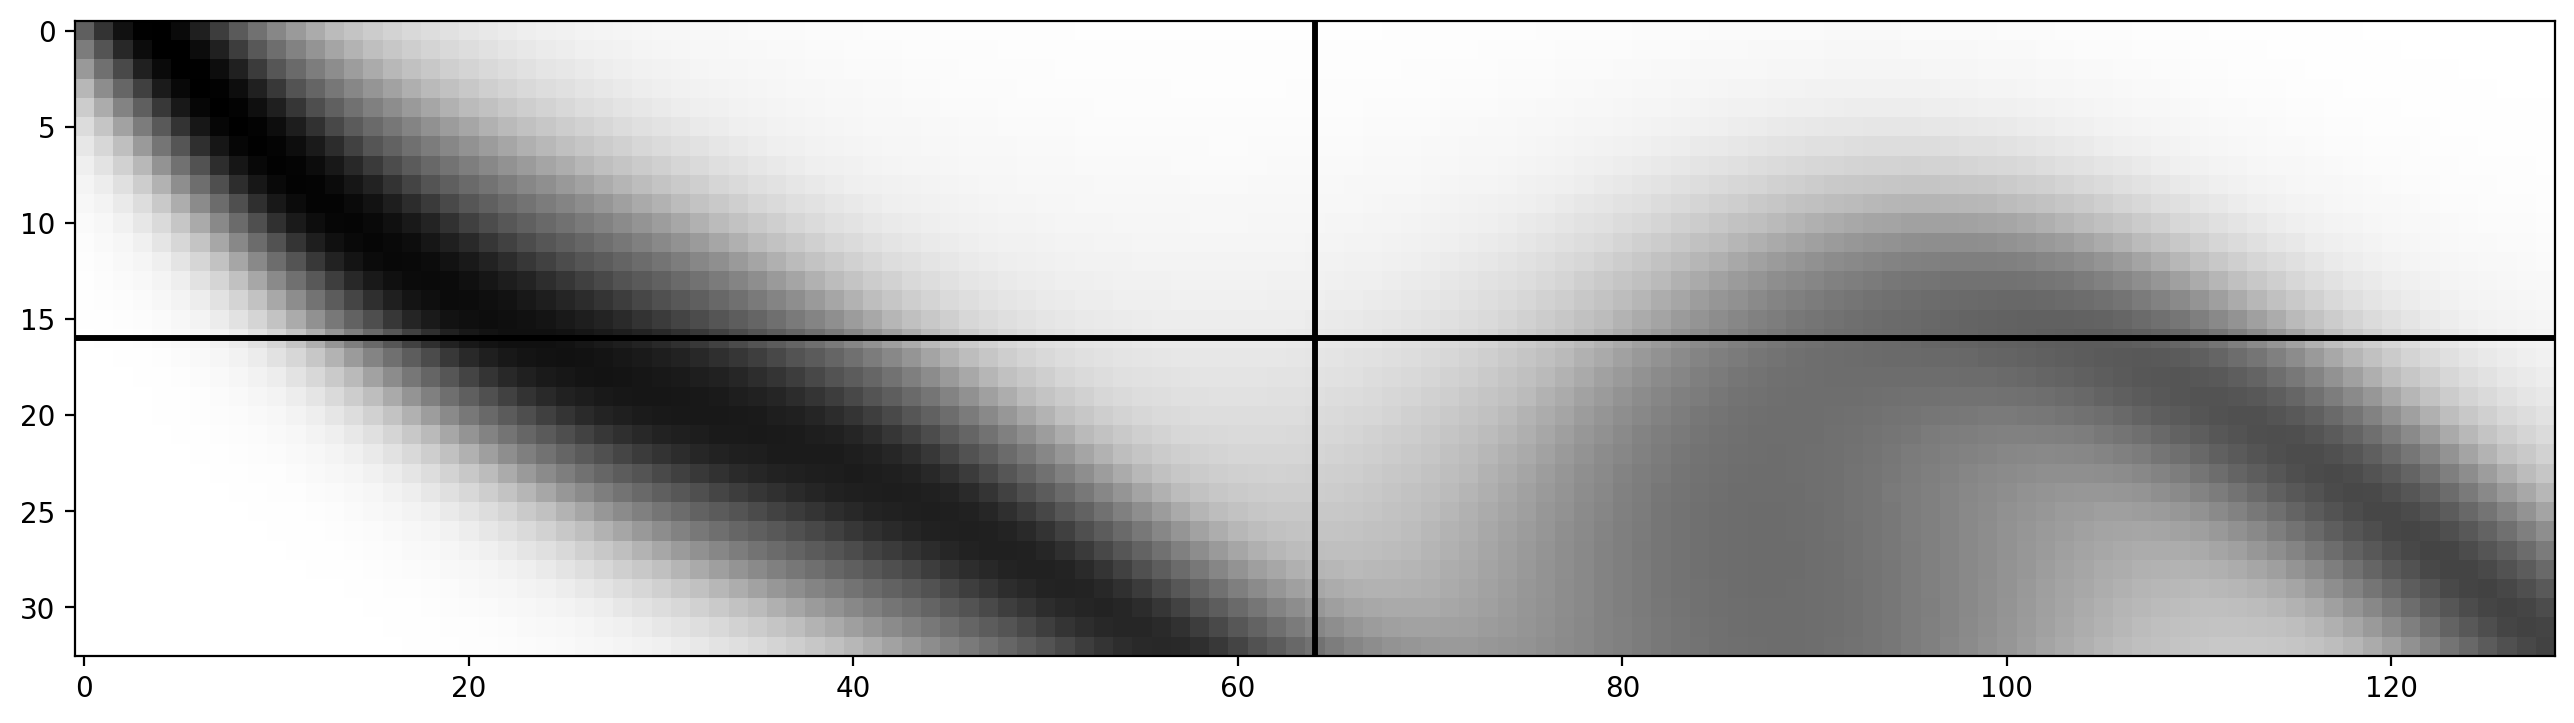

In [38]:

region_example = [[31, 48, 128, 192],
 [48, 65, 128, 192],
 [31, 48, 192, 257],
 [48, 65, 192, 257]]

region_example = [[-1, 16, -1, 64],
 [-1, 16, 64, 129],
 [16, 33, -1, 64],
 [16, 33, 64, 129]]

plt.figure()
plt.figure(figsize=(16,12),dpi=200)
#plt.title('Nested Network')
plt.imshow(val_data[time_slice_num][32:65,128:257],cmap='Greys')
regions = region_example
for region in regions:
    t,b,l,r = region
    h = b-t
    w = r-l
    plt.gca().add_patch(patches.Rectangle((l,t),w,h,linewidth=2,edgecolor='black',facecolor='none'))
    
plt.savefig('fig_proposal4.png')